In [29]:
# 모델 구현 전 환경 설정

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch

  Using cached sentencepiece-0.1.91.tar.gz (500 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached transformers-4.8.2-py3-none-any.whl.metadata (48 kB)
  Using cached huggingface_hub-0.0.12-py3-none-any.whl.metadata (5.6 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached transformers-4.8.2-py3-none-any.whl (2.5 MB)
Using cached 

In [30]:
# KoBERT 라이브러리 설치

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-wrdvac4h/kobert-tokenizer_65febaa2f7af435280bdb4c85d9f17cd
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-wrdvac4h/kobert-tokenizer_65febaa2f7af435280bdb4c85d9f17cd
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done


In [31]:
#import gluonnlp as np 해결

!pip install numpy==1.23.1

In [32]:
# 라이브러리 세팅
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

# koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# 트랜스포머
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [33]:
device = torch.device("cuda:0")
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 데이터 전처리

In [34]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import pandas as pd

# [AI Hub] 감정 분류를 위한 대화 음성 데이터셋 불러오기
chatbot_data = pd.read_excel("/content/drive/MyDrive/capstone_dataset/한국어_단발성_대화_데이터셋.xlsx")

# 5개의 감정 class → 숫자
chatbot_data = chatbot_data[~chatbot_data['Emotion'].isin(["공포", "혐오"])]  # 공포와 혐오 제거

chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 0  # 놀람 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 1  # 분노 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 2  # 슬픔 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 3  # 행복 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  # 중립 => 4

# 데이터 리스트 생성
data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion']):
    data = []
    data.append(q)       # 문장
    data.append(str(label))  # 감정 레이블 (문자열로 변환)
    data_list.append(data)

# 결과 출력
print(data)
print(data_list[:10])


['유재석 오라버니 해피투게더 봤어요', '3']
[[' 7로 나온다든데 아니었나', '0'], ['의사양반 내가고자라니!', '0'], ['이 사람 얼굴이 약간 전라도 사람처럼 생겼네', '0'], ['아직도 안잡았냐??', '0'], ['이분 ~~진짜 욕먹는건 이제 신의 영역에 들어선거같다~~ㅋㅋ', '0'], [' 똥꼬 그냥 확.', '0'], [' 진짜 종횡무진하잖아', '0'], [' 미군 주둔하면 식민지라며? ㅎㄷ', '0'], ['와 한강 이사람도 전라도출신이네', '0'], ['아니 삼성처럼 기업을 운영한.것도 아닌데 어떻게 개인 일가가 8천억이란.', '0']]


In [47]:
# 데이터셋 분류

#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32)

In [48]:
# 데이터셋 토큰화

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [49]:
# 파라미터 세팅

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [50]:
# Data tokenization, int encoding, padding

# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [51]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [52]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 5,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [53]:
# 옵티마이저와 스케줄 설정

# BERT  모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# 학습

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-16-7c6053d2ac68>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/483 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1 batch id 1 loss 1.973890781402588 train acc 0.15625
epoch 1 batch id 201 loss 1.5430103540420532 train acc 0.28505907960199006
epoch 1 batch id 401 loss 1.208729863166809 train acc 0.3836112842892768
epoch 1 train acc 0.40649801587301587


<ipython-input-16-7c6053d2ac68>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 1 test acc 0.522704095147277


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2851388454437256 train acc 0.546875
epoch 2 batch id 201 loss 1.168261170387268 train acc 0.535136815920398
epoch 2 batch id 401 loss 0.9951949119567871 train acc 0.5679940773067331
epoch 2 train acc 0.5739650429414923


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 2 test acc 0.5447393515575333


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9929632544517517 train acc 0.671875
epoch 3 batch id 201 loss 0.8076856732368469 train acc 0.6345615671641791
epoch 3 batch id 401 loss 0.7639612555503845 train acc 0.6638481920199502
epoch 3 train acc 0.667629974695192


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 3 test acc 0.5511496079677898


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.803512454032898 train acc 0.734375
epoch 4 batch id 201 loss 0.515369176864624 train acc 0.7311100746268657
epoch 4 batch id 401 loss 0.5234646797180176 train acc 0.7528834164588528
epoch 4 train acc 0.7575866497967947


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 4 test acc 0.5563612523839796


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6061463356018066 train acc 0.796875
epoch 5 batch id 201 loss 0.4256153702735901 train acc 0.7938432835820896
epoch 5 batch id 401 loss 0.5273540616035461 train acc 0.8096945137157108
epoch 5 train acc 0.810943610536002


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 5 test acc 0.5543779137529138


In [54]:
# 학습 수정 및 손실값 정확도 저장

train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    test_loss = 0.0
    model.train()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        train_acc += calc_accuracy(out, label)
        train_loss += loss.item()  # 손실값 기록

    train_loss_values.append(train_loss / len(train_dataloader))
    train_acc_values.append(train_acc / len(train_dataloader))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        test_acc += calc_accuracy(out, label)
        test_loss += loss.item()

    test_loss_values.append(test_loss / len(test_dataloader))
    test_acc_values.append(test_acc / len(test_dataloader))

    print("epoch {} train acc {} test acc {}".format(e+1, train_acc / len(train_dataloader), test_acc / len(test_dataloader)))


<ipython-input-54-d8115a103de7>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/347 [00:00<?, ?it/s]

<ipython-input-54-d8115a103de7>:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/87 [00:00<?, ?it/s]

epoch 1 train acc 0.527256290179561 test acc 0.6620569923371648


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

epoch 2 train acc 0.7072745788073598 test acc 0.6552721902937421


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

epoch 3 train acc 0.7918352360895589 test acc 0.668881704980843


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

epoch 4 train acc 0.8691012247838616 test acc 0.677242975734355


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

epoch 5 train acc 0.9127791786743515 test acc 0.6764248084291188


In [55]:
def new_softmax(a) :
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)

In [85]:
# 테스트

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            min_v = min(logits)
            total = 0
            probability = []
            logits = np.round(new_softmax(logits), 3).tolist()
            for logit in logits:
                #print(logit) # 추후 주석
                probability.append(np.round(logit, 3))

            if np.argmax(logits) == 0: emotion = "놀람"
            elif np.argmax(logits) == 1: emotion = '분노'
            elif np.argmax(logits) == 2: emotion = '슬픔'
            elif np.argmax(logits) == 3: emotion = '행복'
            elif np.argmax(logits) == 4: emotion = '중립'

            probability.append(emotion)
            #print(probability) # 추후 주석

            # 입력 문장과 함께 결과 출력
            print(f"입력 문장: {predict_sentence}")
            print(f"감정 확률: {logits} , 순서대로 (놀람/분노/슬픔/행복/중립) ")  # 마지막 원소는 감정이므로 제외
            print(f"예측된 감정: {emotion}")
            print("--------------------------------------------------")  # 구분선
    return probability

In [86]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : ㅠㅜㅠㅠ
입력 문장: ㅠㅜㅠㅠ
감정 확률: [21.006999969482422, 1.4140000343322754, 74.69000244140625, 2.618000030517578, 0.2709999978542328] , 순서대로 (놀람/분노/슬픔/행복/중립) 
예측된 감정: 슬픔
--------------------------------------------------


하고싶은 말을 입력해주세요 : 나 너무 잠와
입력 문장: 나 너무 잠와
감정 확률: [0.2540000081062317, 0.20999999344348907, 99.04100036621094, 0.257999986410141, 0.23800000548362732] , 순서대로 (놀람/분노/슬픔/행복/중립) 
예측된 감정: 슬픔
--------------------------------------------------


하고싶은 말을 입력해주세요 : 나 기뻐
입력 문장: 나 기뻐
감정 확률: [0.1899999976158142, 0.057999998331069946, 0.4269999861717224, 99.04299926757812, 0.28299999237060547] , 순서대로 (놀람/분노/슬픔/행복/중립) 
예측된 감정: 행복
--------------------------------------------------


하고싶은 말을 입력해주세요 : 집가자
입력 문장: 집가자
감정 확률: [1.1619999408721924, 1.2569999694824219, 4.139999866485596, 2.634000062942505, 90.80599975585938] , 순서대로 (놀람/분노/슬픔/행복/중립) 
예측된 감정: 중립
--------------------------------------------------


하고싶은 말을 입력해주세요 : 우씨
입력 문장: 우씨
감정 확률: [20.131999969482422, 4.267000198364258

In [87]:
# 모델 저장

import os
os.chdir('/content/drive/MyDrive/capstone_dataset/model/')
os.getcwd()

path = '/content/drive/MyDrive/capstone_dataset/model/'
torch.save(model, path + 'kobert_model.pt')  # 전체 모델 저장

torch.save(model.state_dict(), 'kobert_model_statedict.pt')  # 모델 객체의 state_dict 저장

torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, 'kobert.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [88]:
# 모델 평가 지표

from sklearn.metrics import classification_report

y_true = []  # 실제 라벨
y_pred = []  # 모델의 예측값

# 테스트 데이터셋에 대한 예측
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)

    out = model(token_ids, valid_length, segment_ids)
    pred = np.argmax(out.detach().cpu().numpy(), axis=1)

    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred)

# 분류 결과 보고
print(classification_report(y_true, y_pred, target_names=["놀람", "분노", "슬픔", "행복", "중립"]))


              precision    recall  f1-score   support

          놀람       0.60      0.63      0.62      1160
          분노       0.70      0.68      0.69      1145
          슬픔       0.73      0.78      0.76      1040
          행복       0.80      0.80      0.80      1188
          중립       0.52      0.47      0.50      1007

    accuracy                           0.68      5540
   macro avg       0.67      0.67      0.67      5540
weighted avg       0.67      0.68      0.68      5540



/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45440 (\N{HANGUL SYLLABLE NOL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49836 (\N{HANGUL SYLLABLE SEUL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54548 (\N{HANGUL SYLLABLE PEUM}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabo

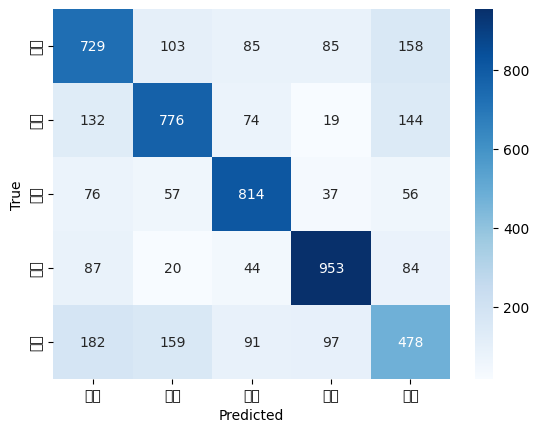

In [89]:
# 혼동 행렬 (Confusion Matrix)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["놀람", "분노", "슬픔", "행복", "중립"], yticklabels=["놀람", "분노", "슬픔", "행복", "중립",])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

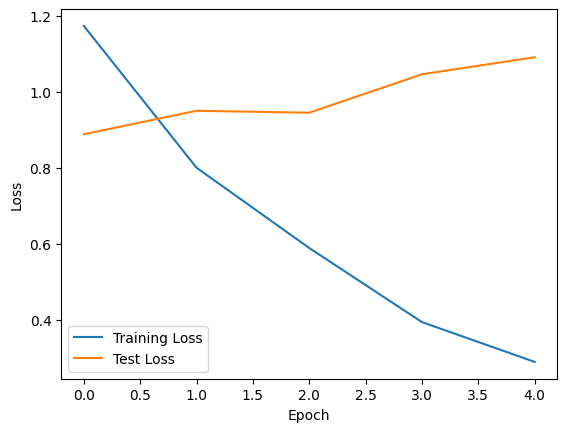

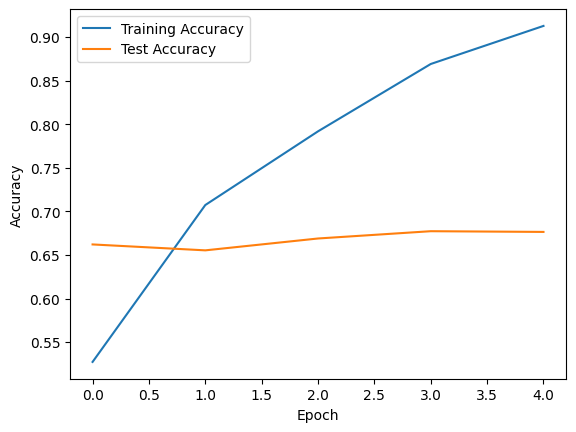

In [90]:
1 # Loss(손실) 및 Accuracy(정확도) 추이 분석

# 손실값 그래프
plt.plot(train_loss_values, label="Training Loss")
plt.plot(test_loss_values, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(train_acc_values, label="Training Accuracy")
plt.plot(test_acc_values, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()